# **Всем привет!**

Это файл решения, мне показалось, что в формате блокнота его будет удобно смотреть. 

Файл с конечным ответом залит в папку на гите. 



### Собственно, перейдем к решению:)

Предварительно я разбила тестовый файл на две эксель-таблички: с данными из реестра и отчетом, чтобы было легче импортировать. 

Импортируем таблицу с данными из реестра и приводим ее в человеческий вид

In [57]:
import pandas as pd
import numpy as np

data_row = pd.read_excel('Тестовое задание для стажировки по аналитике_ Датасет.xlsx', header=1)
data = pd.DataFrame(data_row['Реестр'].str.replace(r'от ', ''))

data[['todrop','id', 'todrop2', 'sum', 'date']] = data.pop('Реестр').str.split(expand=True)
data[['day','month', 'year']] = data.pop('date').str.split(pat = '.',expand=True)
data = data.drop(data.columns[[0, 2]], axis=1)
data[['id', 'sum', 'month', 'day']] = data[['id', 'sum', 'month', 'day']].apply(pd.to_numeric)
data[:5]

,id,sum,day,month,year
0,21,3468.72,7,1,2020
1,22,9264.84,2,1,2020
2,23,9593.12,31,1,2020
3,24,7798.25,30,1,2020
4,25,4425.30,24,1,2020


Посмотрим, что там вообще происходит с месяцами - может быть, сумма хотя бы по одному месяцу совпадает

In [58]:
data.groupby('month').sum()[['sum']]

,sum
month,
1,345374.36
2,498233.18
3,544735.84
4,324724.69
5,508730.49
6,458221.06
7,75447.74
8,88548.74
9,100853.88


Кажется, все очень плохо: месяцев сильно больше 6, есть несуществующие месяцы, суммы по месяцам нигде не совпадают.

Думаем дальше.

In [59]:
data

,id,sum,day,month,year
0,21,3468.72,7,1,2020
1,22,9264.84,2,1,2020
2,23,9593.12,31,1,2020
3,24,7798.25,30,1,2020
4,25,4425.30,24,1,2020
...,...,...,...,...,...
655,606,6548.01,6,19,2020
656,607,6597.90,3,2,2020
657,608,2526.00,8,6,2020
658,609,8097.32,13,6,2020


Кажется, что-то не так с id - похоже, они идут в порядке возрастания, но последний номер id меньше, чем последний индекс таблицы.

Что происходит с порядком id - наши догадки:
1) Возрастающий порядок с шагом 1- не правило для id и они распределены по логике, не связанной с месяцами

2) Возрастающий порядок с шагом 1 есть, но ряд id дублируются из-за ошибок

3) Возрастающий порядок с шагом 1 сохраняется внутри месяца, с каждым новым месяцем отсчет начинается с выпадающего из последовательности числа

Или произошло что-то другое, но сначала проверим эти догадки

Посмотрим, верно ли одно из этих предположений с помощью диаграммы

<function matplotlib.pyplot.show(close=None, block=None)>

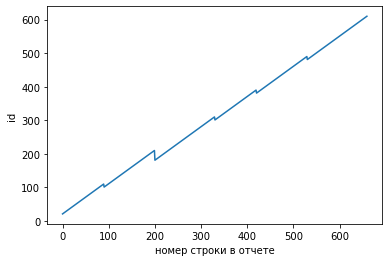

In [115]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(data['id'])

ax.set_xlabel('номер строки в отчете')
ax.set_ylabel('id')

plt.show

Кажется, верным оказалось предположение 3)

Мы видим, что у графика есть 5 скачков, которые могут совпадать с переходом от одного месяца к другому (ведь месяцев в отчете 6). 

Проверим это:

In [61]:
# Заменяем месяцы на верные по нашему предположению
j = 1
k = 0
for i in range(len(data)-1):
    if data['id'][i + 1] < data['id'][i]:
        data['month'][k:i+1] = j
        j += 1
        k = i + 1

data['month'][k:len(data)+1] = 6
        
    

<ipython-input-61-c80655d65526>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'][k:i+1] = j
<ipython-input-61-c80655d65526>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'][k:len(data)+1] = 6


Проверим, совпадает ли это с отчетом из задания.

In [67]:
#строим свой отчет
data_report = data.groupby('month').sum()[['sum']]

In [63]:
#импортируем отчет из задания
report = pd.read_excel('otchet.xlsx', header=0)
report.loc[report['Месяц'] == 'январь', 'Месяц'] = 1
report.loc[report['Месяц'] == 'февраль', 'Месяц'] = 2
report.loc[report['Месяц'] == 'март', 'Месяц'] = 3
report.loc[report['Месяц'] == 'апрель', 'Месяц'] = 4
report.loc[report['Месяц'] == 'май', 'Месяц'] = 5
report.loc[report['Месяц'] == 'июнь', 'Месяц'] = 6

In [112]:
result = pd.merge(report, data_report, how="inner",left_on='Месяц',right_on='month', left_index=False,right_index=False)

def compare(x):
    assert x['sum'].all() == x['Сумма'].all(), 'Есть ошибки, наш подход неверен'
    return print('Вау, все и правда совпало. Осталось только выгрузить поправленный отчет в эксель и скинуть в отдел Реестров.')

compare(result)
result

Вау, все и правда совпало. Осталось только выгрузить поправленный отчет в эксель и скинуть в отдел Реестров.


,Месяц,Сумма,sum
0,1,485487.84,485487.84
1,2,570192.91,570192.91
2,3,698723.40,698723.40
3,4,444834.87,444834.87
4,5,574488.89,574488.89
5,6,579810.45,579810.45


In [116]:
data.to_csv('Ответ_Масленникова Светлана.csv')

### Вот, вроде бы, и все решение :)